## Modelling Draft: MobileNet for M-Stage Classification<br>
Framework: Tensorflow Keras <br>
Base models to test: <br>
<li>Xception </li>
<li>MobileNet ✓</li>
<li>NasNet Mobile </li>

#### Import Packages

In [1]:
# import numpy as np
# from PIL import Image
# from tensorflow.keras import backend as K
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
import random
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, BatchNormalization, Flatten, Input
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from time import perf_counter

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
print ('All modules are loaded')

All modules are loaded


In [2]:
#Labels
# t_stg= ['is','1','1a','1b','1c','2','2a','2b','3','4']
# n_stg = ['0','1','2','3']
m_stg = ['0','1','1a','1b','1c','2','3'] 

#Load the image batches, labels == t,m,n
m_raw_df = pd.read_csv(r'D:\Lung-PET-CT-Dx\manifest\raw_ct_delimited.csv',usecols=['filenames','m'])
# seg_df = pd.read_csv(r'D:\Lung-PET-CT-Dx\manifest\segmented ct image files.csv',usecols=['filenames','labels'])
raw_dir = r'C:\Users\lzsnc\Desktop\Raw CT Images'
# seg_dir = r'C:\Users\lzsnc\Desktop\Masked CT images'
m_raw_df.head()
# seg_df.head()
os.chdir(r'C:\Users\lzsnc\Desktop\Raw CT Images')

In [3]:
m_raw_df.head()

,filenames,m
0,Lung_Dx-A0001_04-04-2007-NA-Chest-07990_2.000000-5mm-40805_1-13.tiff,1b
1,Lung_Dx-A0001_04-04-2007-NA-Chest-07990_2.000000-5mm-40805_1-14.tiff,1b
2,Lung_Dx-A0001_04-04-2007-NA-Chest-07990_2.000000-5mm-40805_1-15.tiff,1b
3,Lung_Dx-A0001_04-04-2007-NA-Chest-07990_2.000000-5mm-40805_1-16.tiff,1b
4,Lung_Dx-A0001_04-04-2007-NA-Chest-07990_2.000000-5mm-40805_1-17.tiff,1b


#### Split Dataset: <br>
80% Train, 20% Test

In [4]:
m_train_df, m_test_df = train_test_split(m_raw_df, test_size=0.2, random_state=42) 
m_train_df.tail()
#convert m-stage df to string
m_train_df['m'] = m_train_df['m'].apply(str)
m_test_df['m'] = m_test_df['m'].apply(str)

#### Train/Test for 'T' Stage

In [5]:
train_batch = 32
train_datagen = ImageDataGenerator(rescale=1 / 255.0,
                                   featurewise_center=True,
                                   featurewise_std_normalization=True,)

m_train_ds = train_datagen.flow_from_dataframe(
    dataframe=m_train_df,
    directory=raw_dir,
    target_size=(224,224),    
    x_col='filenames',
    y_col='m',
    # color_mode='grayscale',
    class_mode='categorical',
    shuffle=True,
    seed=32
)

Found 24250 validated image filenames belonging to 7 classes.


In [6]:
np.unique(m_train_ds.classes)

array([0, 1, 2, 3, 4, 5, 6])

#### Test Image Generator

In [7]:
test_batch = 32
test_datagen = ImageDataGenerator(rescale=1 / 255.0)
m_test_ds = test_datagen.flow_from_dataframe(
    dataframe=m_test_df,
    directory=raw_dir,
    target_size=(224,224),    
    x_col='filenames',
    y_col='m',
    # color_mode='grayscale',
    class_mode='categorical',
    shuffle=False, #re-run this!
    seed=32 
)

Found 6063 validated image filenames belonging to 7 classes.


In [8]:
#Check number of classes
m_class_dict = m_train_ds.class_indices
print(m_class_dict)
m_num_classes = len(m_class_dict)
m_num_classes

{'0': 0, '1': 1, '1a': 2, '1b': 3, '1c': 4, '2': 5, '3': 6}


7

In [9]:
m_class_dict

{'0': 0, '1': 1, '1a': 2, '1b': 3, '1c': 4, '2': 5, '3': 6}

Add weights

In [10]:
#without undersampling oversamples:
m_class_weights = class_weight.compute_class_weight(
           class_weight='balanced',
           classes=np.unique(m_train_ds.classes),
           y=m_train_ds.classes)
m_class_weights = dict(zip(np.unique(m_train_ds.classes), m_class_weights))
m_class_weights

{0: 0.2078155797411946,
 1: 0.7223281305850113,
 2: 4.390729675900778,
 3: 3.025577043044292,
 4: 4.229897087039944,
 5: 247.44897959183675,
 6: 203.78151260504202}

Model 2: MobileNet

In [11]:
base_model = MobileNet(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [12]:
#Add random seed
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tensorflow.random.set_seed(seed_value) #use in dropout

In [13]:
#Create the model
model = Sequential()
model.add(base_model)
# model.add(Dropout(0.3))
model.add(tensorflow.keras.layers.GlobalAveragePooling2D())
model.add(BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001))
model.add(tensorflow.keras.layers.Reshape((-1,1)))
model.add(tensorflow.keras.layers.AveragePooling1D())
model.add(Flatten())
model.add(Dropout(0.3,seed=seed_value))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3,seed=seed_value))
model.add(Dense(m_num_classes,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 reshape (Reshape)           (None, 1024, 1)           0         
                                                                 
 average_pooling1d (Average  (None, 512, 1)            0         
 Pooling1D)                                             

In [15]:
learning_rate = 0.0001
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

Actual Training

In [16]:
os.chdir(r'D:\Lung-PET-CT-Dx\manifest\Models')
checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint("multiclass_m_stage_mobilenet_v3.h5",
                     save_best_only=True, # only keep the best model weights on file (delete the rest)
                     save_weights_only=False,   # save only the model weights
                     verbose=1, # don't print out whether or not model is being saved
                     monitor='val_loss')
early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              mode='auto',
                                              patience=5)

In [17]:
start = perf_counter()
history = model.fit(m_train_ds,
                    epochs=20,
                    steps_per_epoch=len(m_train_ds),
                    validation_data=m_test_ds,
                    validation_steps=len(m_test_ds),
                    callbacks=[checkpoint_callback, early_stop],
                    verbose=1,
                    class_weight=m_class_weights)
end = perf_counter()
print(end - start)


Epoch 1/20
758/758 [==============================] - ETA: 0s - loss: 2.0472 - accuracy: 0.2876
Epoch 1: val_loss improved from inf to 1.72866, saving model to multiclass_m_stage_mobilenet_v3.h5
758/758 [==============================] - 702s 923ms/step - loss: 2.0472 - accuracy: 0.2876 - val_loss: 1.7287 - val_accuracy: 0.2977
Epoch 2/20
758/758 [==============================] - ETA: 0s - loss: 1.5326 - accuracy: 0.2764
Epoch 2: val_loss improved from 1.72866 to 1.66214, saving model to multiclass_m_stage_mobilenet_v3.h5
758/758 [==============================] - 508s 669ms/step - loss: 1.5326 - accuracy: 0.2764 - val_loss: 1.6621 - val_accuracy: 0.3107
Epoch 3/20
758/758 [==============================] - ETA: 0s - loss: 1.3520 - accuracy: 0.2947
Epoch 3: val_loss improved from 1.66214 to 1.57121, saving model to multiclass_m_stage_mobilenet_v3.h5
758/758 [==============================] - 420s 554ms/step - loss: 1.3520 - accuracy: 0.2947 - val_loss: 1.5712 - val_accuracy: 0.3350
Ep

Approximate training time: 8964.6886161 seconds

In [18]:
#Evaluate performance
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

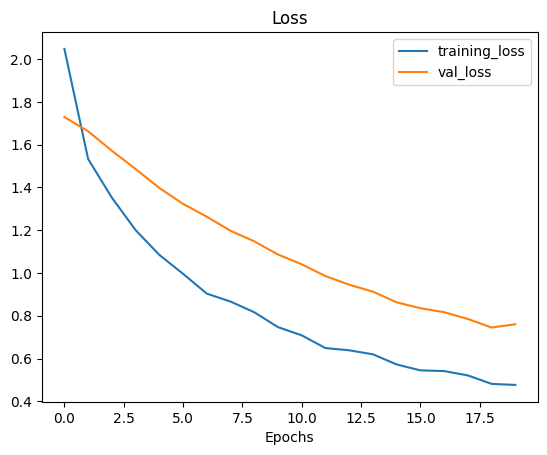

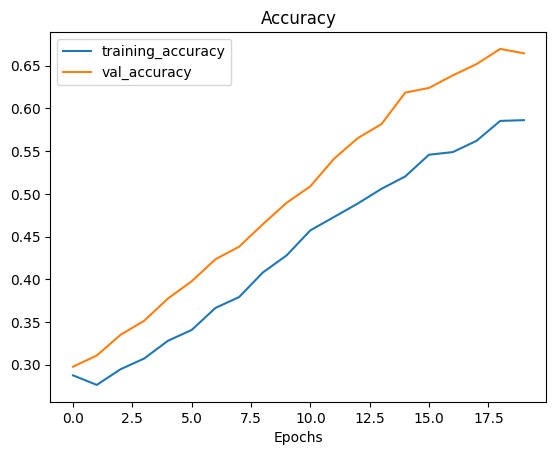

In [19]:
plot_loss_curves(history)

190/190 [==============================] - 84s 437ms/step
Confusion Matrix
Classification Report for M-Stage
              precision    recall  f1-score   support

           0       0.96      0.58      0.72      4181
           1       0.56      0.81      0.66      1249
          1a       0.25      0.97      0.40       174
          1b       0.41      0.96      0.57       269
          1c       0.41      0.97      0.58       184
           2       0.50      1.00      0.67         2
           3       0.19      1.00      0.32         4

    accuracy                           0.66      6063
   macro avg       0.47      0.90      0.56      6063
weighted avg       0.82      0.66      0.69      6063



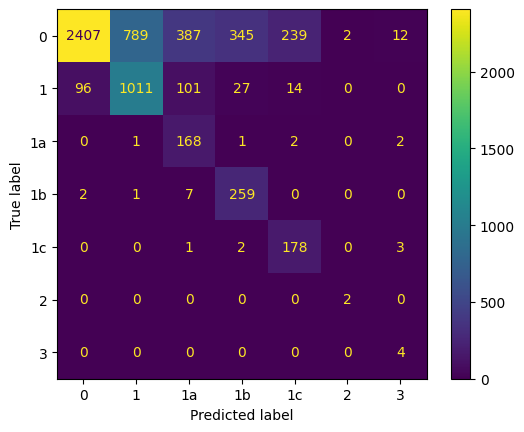

In [20]:
m_Y_pred = model.predict(m_test_ds) #predictions
m_Y_ground = m_test_df.m.to_list()
m_y_pred = np.argmax(m_Y_pred,axis=1)
print('Confusion Matrix')
cm = confusion_matrix(m_test_ds.classes, m_y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=m_stg)
cmd.plot()

print('Classification Report for M-Stage')

print(classification_report(m_test_ds.classes, m_y_pred, target_names=m_stg))


In [21]:
from tensorflow.keras.preprocessing import image
test_img = r'Raw CT Images\Lung_Dx-A0065_10-26-2008-NA-lungc-32319_3.000000-5mm Lung SS50-68818_1-34.tiff'
test = image.load_img(test_img, target_size=(224,224))
test_img_array = image.img_to_array(test)
img_batch = np.expand_dims(test_img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
prediction = model.predict(img_preprocessed)
print(prediction[0])

1/1 [==============================] - 1s 532ms/step
[0.16220465 0.10172363 0.5174141  0.1337574  0.01237867 0.02442367
 0.04809779]
